In [1]:
%pip install swat

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np 
import swat
import requests
import json
import os 
import random
from sasviya.ml.tree import ForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
SEED = 42  
np.random.seed(SEED)
random.seed(SEED)
pd.options.display.max_columns = None
pd.options.display.max_rows = 50

### Data Analysis and Machine Learning Modelling

In [3]:
df_data = pd.read_csv('data/CUSTOMS.csv')
print('Available Rows:', df_data.shape[0], '\nAvailable Features:', df_data.shape[1]-1)
df_data.head(2)

Available Rows: 7043 
Available Features: 20


,CertificateOfOrigin,EUCitizen,Perishable,Fragile,Volume,PreDeclared,MultiplePackage,Category,OnlineDeclaration,ExporterValidation,SecuredDelivery,LithiumBatteries,ExpressDelivery,EntryPoint,Origin,PaperlessBilling,PaymentMethod,Weight,Price,Inspection,packageID
0,No,0,Yes,No,2,No,NaN,Clothing,No,Yes,No,No,No,Antwerp,China,Yes,Electronic check,29.85,29.85,No,7590-VHVEG
1,Yes,0,No,No,35,Yes,No,Clothing,Yes,No,Yes,No,No,Antwerp,US,No,Mailed check,56.95,1889.50,No,5575-GNVDE


In [4]:
percent_missing = df_data.isnull().sum() * 100 / len(df_data)
number_missing = df_data.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': df_data.columns,
                                 'number_missing':number_missing,
                                 'percent_missing': percent_missing}).reset_index(drop=True)
missing_value_df[missing_value_df['percent_missing']>0].sort_values('percent_missing', ascending=False).set_index('column_name')

,number_missing,percent_missing
column_name,,
OnlineDeclaration,1526,21.666903
ExporterValidation,1526,21.666903
SecuredDelivery,1526,21.666903
ExpressDelivery,1526,21.666903
LithiumBatteries,1526,21.666903
MultiplePackage,682,9.683374
Price,11,0.156183


In [5]:
target = 'Inspection'
pd.concat([df_data[target].value_counts().to_frame(), df_data[target].value_counts(normalize=True).to_frame()], axis=1)

,count,proportion
Inspection,,
No,5174,0.73463
Yes,1869,0.26537


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CertificateOfOrigin  7043 non-null   object 
 1   EUCitizen            7043 non-null   int64  
 2   Perishable           7043 non-null   object 
 3   Fragile              7043 non-null   object 
 4   Volume               7043 non-null   int64  
 5   PreDeclared          7043 non-null   object 
 6   MultiplePackage      6361 non-null   object 
 7   Category             7043 non-null   object 
 8   OnlineDeclaration    5517 non-null   object 
 9   ExporterValidation   5517 non-null   object 
 10  SecuredDelivery      5517 non-null   object 
 11  LithiumBatteries     5517 non-null   object 
 12  ExpressDelivery      5517 non-null   object 
 13  EntryPoint           7043 non-null   object 
 14  Origin               7043 non-null   object 
 15  PaperlessBilling     7043 non-null   o

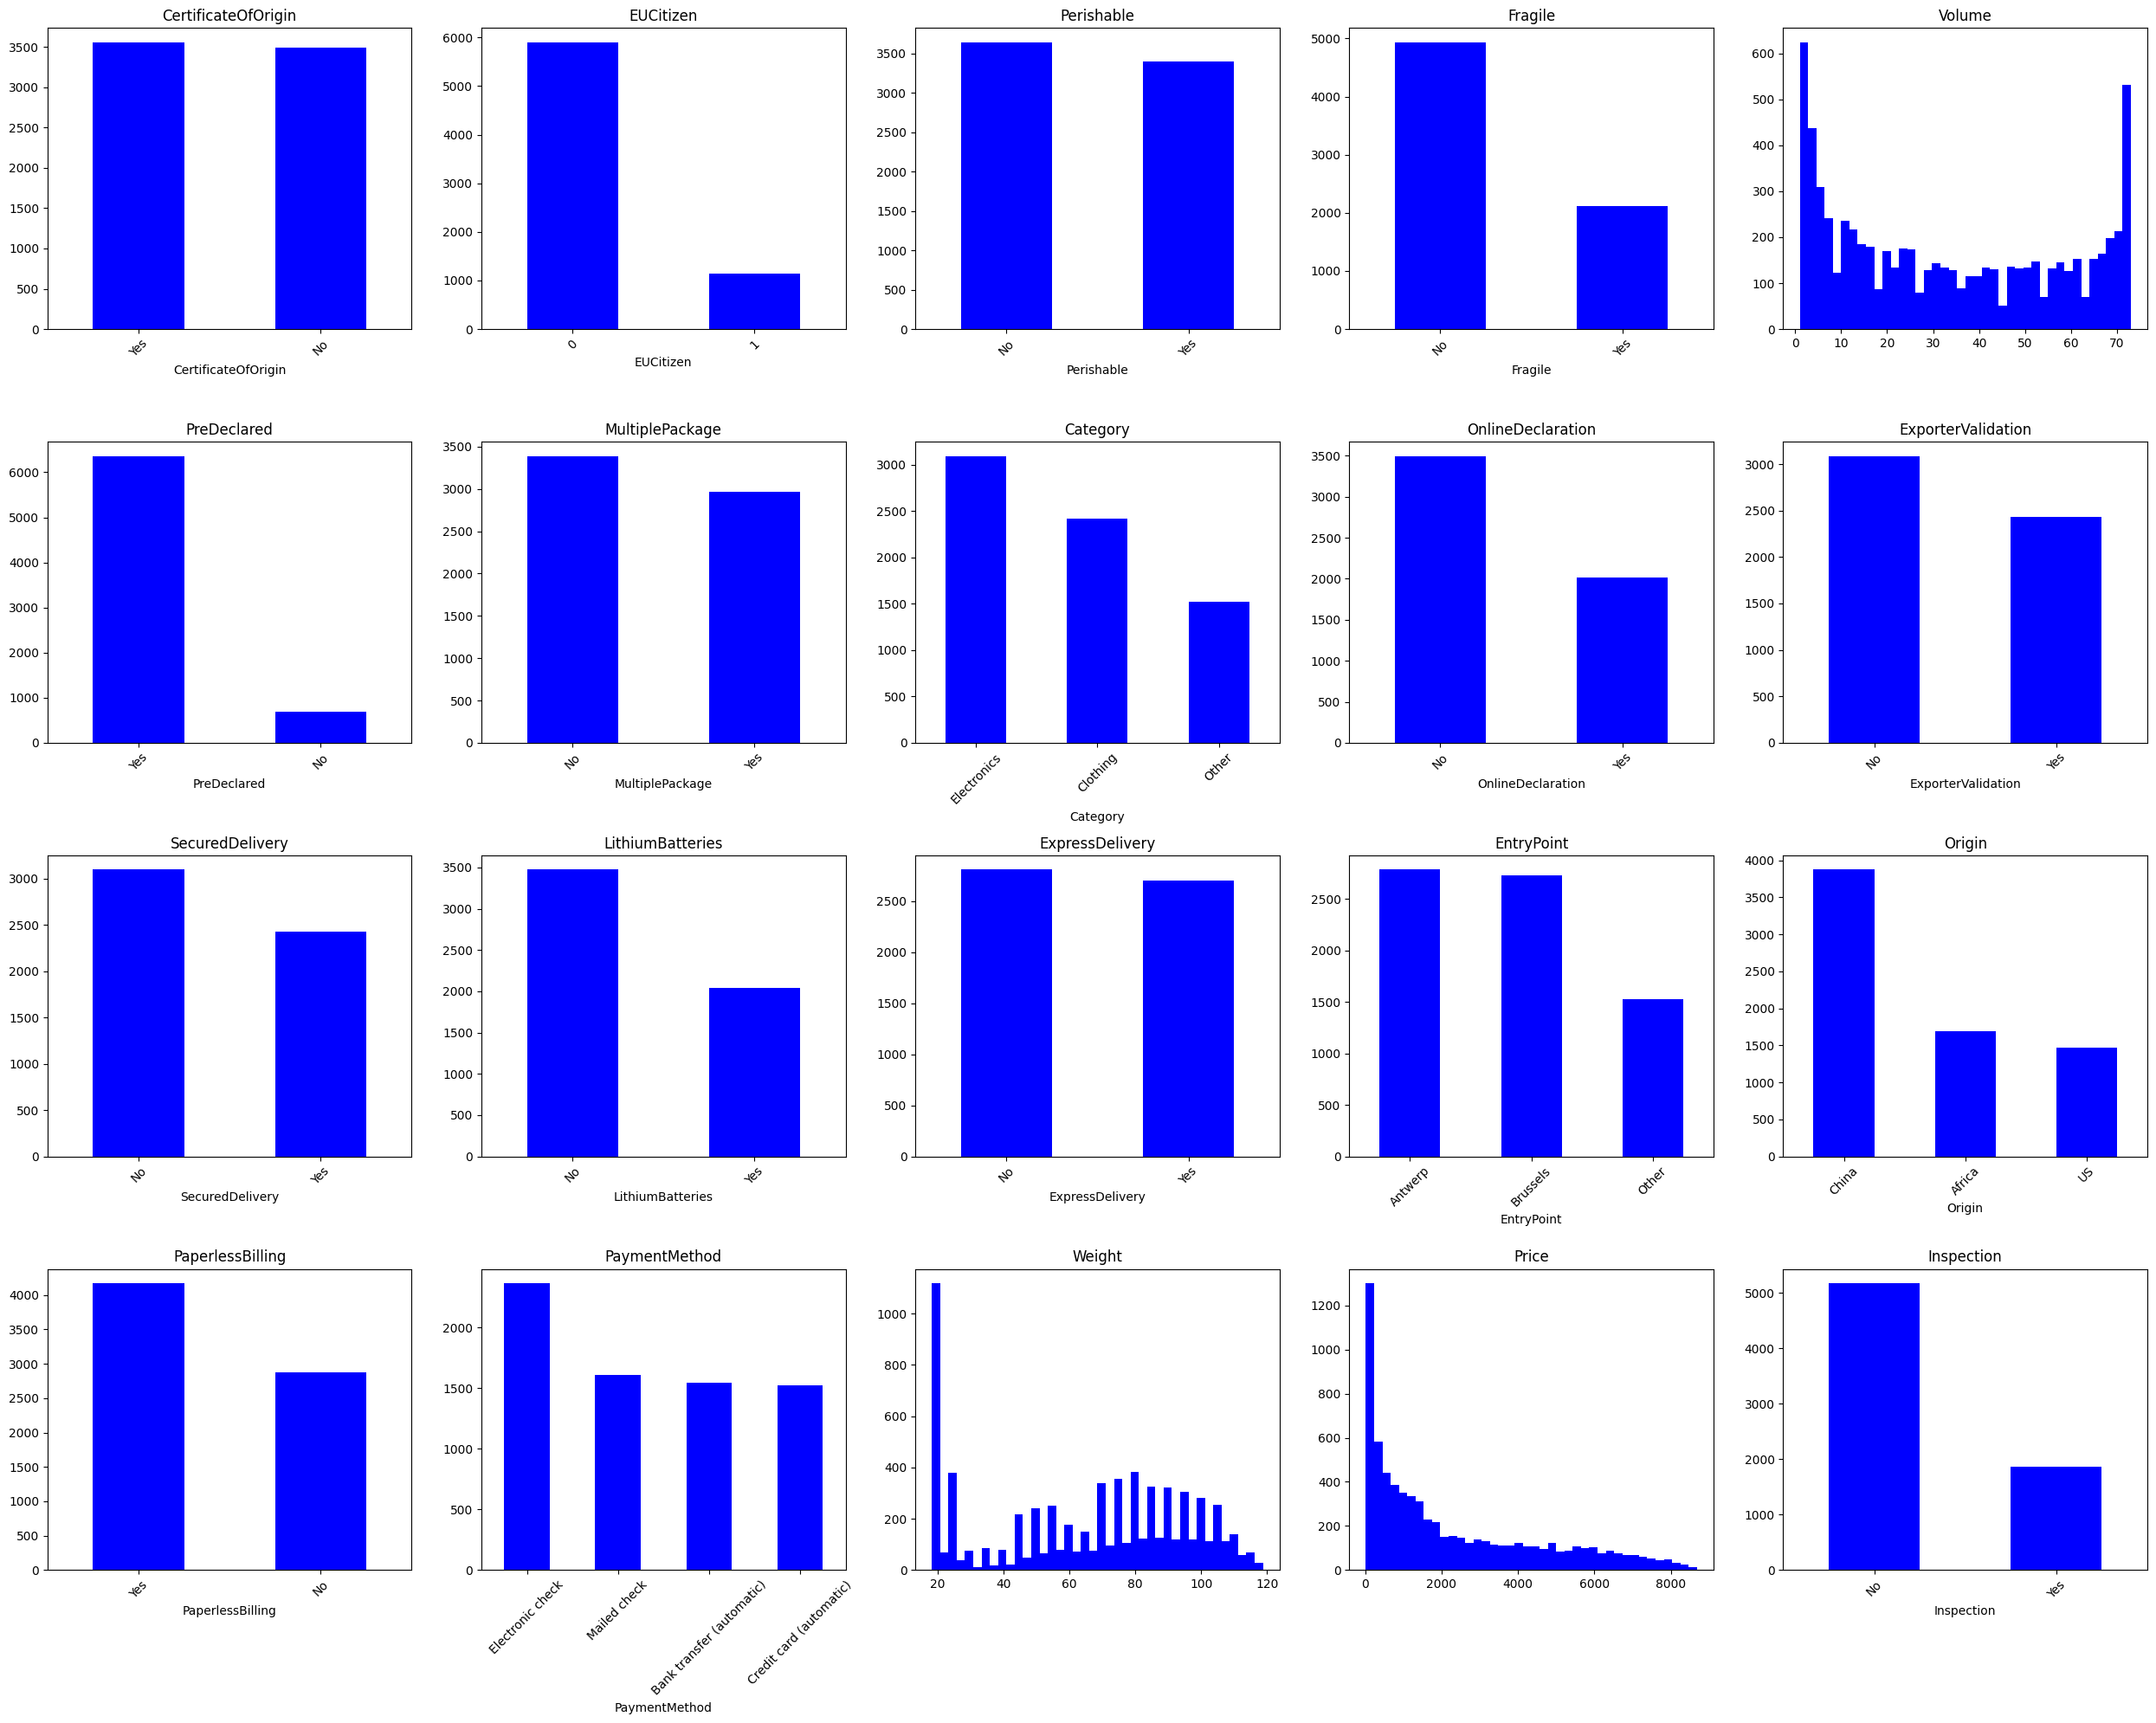

In [7]:
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(25, 20))
axs = axs.ravel()
columns = list(df_data.columns)
del (columns[columns.index('packageID')])
for i in range(len(axs)):
    ax=axs[i]
    if df_data[columns[i]].dtype =='float64' or columns[i]=='Volume':
        ax.hist(df_data[columns[i]], bins=40, color='blue')
    else:
        df_data[columns[i]].value_counts().plot(kind='bar', ax=ax, color='blue', rot=45)
    ax.set_title(columns[i])
plt.tight_layout()
plt.show()

In [8]:
df_data.loc[df_data['Inspection']=='Yes', 'Inspection']=1
df_data.loc[df_data['Inspection']=='No', 'Inspection']=0
df_data['Inspection'] = df_data['Inspection'].astype(int)

In [9]:
train, test = train_test_split(df_data, train_size=0.8, stratify=df_data['Inspection'], random_state=SEED)
print('Train Size:', train.shape[0], '--- Inspection Frequency:', f'{round(100*train.Inspection.sum()/train.shape[0],2)}%')
print('Test Size:', test.shape[0], '--- Inspection Frequency:', f'{round(100*test.Inspection.sum()/test.shape[0],2)}%')

Train Size: 5634 --- Inspection Frequency: 26.54%
Test Size: 1409 --- Inspection Frequency: 26.54%


In [10]:
features = ['CertificateOfOrigin', 'EUCitizen', 'Perishable', 'Fragile', 'Volume',
            'PreDeclared', 'MultiplePackage', 'Category', 'OnlineDeclaration',
            'ExporterValidation', 'SecuredDelivery', 'LithiumBatteries',
            'ExpressDelivery', 'EntryPoint', 'Origin', 'PaperlessBilling',
            'PaymentMethod', 'Weight', 'Price']
target = 'Inspection'

In [11]:
model = ForestClassifier(random_state=SEED)
model.fit(train[features], train[target].to_numpy())

ForestClassifier(random_state=42)

Test F1 Score: 60.0


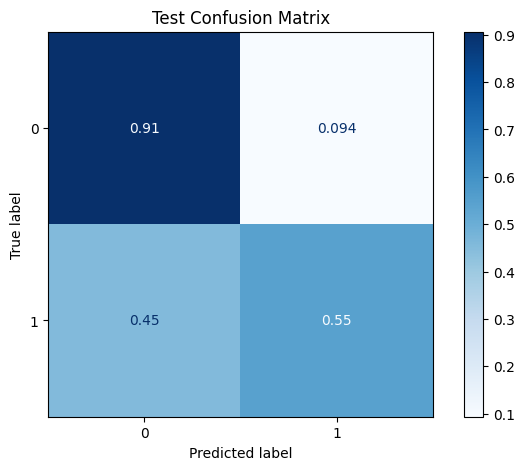

In [12]:
print('Test F1 Score:', 100*round(f1_score(test[target], model.predict(test[features])),2))
fig, ax = plt.subplots(figsize=(8,5))
disp = ConfusionMatrixDisplay(confusion_matrix(test[target], model.predict(test[features]), normalize='true'))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Test Confusion Matrix')
plt.show()

In [13]:
test['I_Inspection']=model.predict(test[features])
test['P_Inspection1']=model.predict_proba(test[features]).iloc[:, 1]
test['P_Inspection0']=model.predict_proba(test[features]).iloc[:, 0]
model.export('Optimized_Forest.astore', replace=True)
model.save('Optimized_Forest.pkl')

### Calling SWAT Actions

In [14]:
def _connect_to_instance(refresh_token, verification):
	url = "https://create.demo.sas.com"
	auth_url = f"{url}/SASLogon/oauth/token"
	# reading long-lived refresh token from txt file

	payload=f'grant_type=refresh_token&refresh_token={refresh_token}'
	headers = {
	'Accept': 'application/json',
	'Content-Type': 'application/x-www-form-urlencoded',
	'Authorization': 'Basic c2FzLmNsaTo=',
	}

	response = requests.request("POST", auth_url, headers=headers, data=payload, verify=verification)
	access_token = response.json()['access_token']
	return access_token

def _generate_access_token(auth_code, verification):
	server = "https://create.demo.sas.com" 
	url = f"{server}/SASLogon/oauth/token"

	payload = f'grant_type=authorization_code&code={auth_code}'
	headers = {
		'Accept': 'application/json',
		'Content-Type': 'application/x-www-form-urlencoded',
		'Authorization': 'Basic c2FzLmNsaTo='
	}

	response = requests.request("POST", url, headers=headers, data=payload, verify=verification)

	# Parse the response text
	response_json = json.loads(response.text)

	# Get the refresh token
	refresh_token = response_json['refresh_token']
	return refresh_token

def get_connection(verify=False):
	if 'refresh_token.txt' not in [i.name for i in os.scandir()]:
		with open('refresh_token.txt', 'w') as file:
			file.write('test')
	if verify:
		os.environ['CAS_CLIENT_SSL_CA_LIST'] = 'ssemonthly-rootCA-Intermidiates_4CLI.pem'
		verify = 'ssemonthly-rootCA-Intermidiates_4CLI.pem'
	try:
		with open('refresh_token.txt', 'r') as token:
			refresh_token = token.read()
		access_token = _connect_to_instance(refresh_token, verify)

	except:
		print('https://create.demo.sas.com/SASLogon/oauth/authorize?client_id=sas.cli&response_type=code')
		auth_code = input('Please provide your access token by going to https://create.demo.sas.com/SASLogon/oauth/authorize?client_id=sas.cli&response_type=code:')
		refresh_token = _generate_access_token(auth_code, verify)
		with open('refresh_token.txt', 'w') as file:
			file.write(refresh_token)
		access_token = _connect_to_instance(refresh_token, verify)
	print('Connected!')
	return access_token

In [15]:
access_token = get_connection(verify=True)
s=swat.CAS('https://create.demo.sas.com/cas-shared-default-http', password=access_token)

Connected!


In [16]:
table_name_test = 'test_scored_data'
s.upload_frame(test, casout={'name':table_name_test, 'caslib':'casuser', 'replace':True})
table_name_train = 'train_data'
s.upload_frame(train.sample(frac=0.7), casout={'name':table_name_train, 'caslib':'casuser', 'replace':True})

NOTE: Cloud Analytic Services made the uploaded file available as table TEST_SCORED_DATA in caslib CASUSER(Fabio.Ceruti@sas.com).
NOTE: The table TEST_SCORED_DATA has been created in caslib CASUSER(Fabio.Ceruti@sas.com) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN_DATA in caslib CASUSER(Fabio.Ceruti@sas.com).
NOTE: The table TRAIN_DATA has been created in caslib CASUSER(Fabio.Ceruti@sas.com) from binary data uploaded to Cloud Analytic Services.


CASTable('TRAIN_DATA', caslib='CASUSER(Fabio.Ceruti@sas.com)')

In [17]:
s.loadactionset('fairaitools')
s.fairaitools.assessbias(
    modelTableType='NONE',
    table=table_name_test,
    predictedVariables='I_Inspection',
    response='Inspection',
    sensitiveVariable='Origin' 
)

NOTE: Added action set 'fairaitools'.
NOTE: Active Session now server.
NOTE: The result table 'GroupMetrics' has been created.
NOTE: The result table 'MaxDifferences' has been created.
NOTE: The result table 'BiasMetrics' has been created.


[BiasMetrics]

 Bias Metrics
 
              Metric        MetricLabel     Value   Base Compare Note
 0  PredictiveParity  Predictive Parity  0.384419  China  Africa     

[GroupMetrics]

 Group Metrics
 
     Group      N       ASE      RASE       MAE      RMAE      MSLE     RMSLE  PREDICTED  I_Inspection
 0  Africa  349.0  0.031519  0.177535  0.031519  0.177535  0.015143  0.123058   0.000000      0.000000
 1   China  783.0  0.288633  0.537246  0.288633  0.537246  0.138675  0.372391   0.384419      0.384419
 2      US  277.0  0.108303  0.329095  0.108303  0.329095  0.052035  0.228111   0.000000      0.000000

[MaxDifferences]

 Max Differences
 
          Metric                         MetricLabel     Value   Base Compare
 0  I_Inspection                Average I_Inspection  0.384419  China  Africa
 1           ASE                Average Square Error  0.257115  China  Africa
 2          RASE           Root Average Square Error  0.359711  China  Africa
 3           MAE                 Mean Absolute Error  0.257115  China  Africa
 4          RMAE            Root Mean Absolute Error  0.359711  China  Africa
 5          MSLE       Mean Square Logarithmic Error  0.123532  China  Africa
 6         RMSLE  Root Mean Square Logarithmic Error  0.249333  China  Africa
 7     PREDICTED                  Average Prediction  0.384419  China  Africa

+ Elapsed: 0.267s, user: 0.0873s, sys: 0.0506s, mem: 1.69mb

In [18]:
s.loadactionset('generativeAdversarialNet')
results= s.tabularGanTrain(
            table        = {"name":"TRAIN_DATA", 
                                "vars": {
                                        "CertificateOfOrigin", "EUCitizen", "Perishable", "Fragile", "Volume",
                                        "PreDeclared", "MultiplePackage", "Category", "OnlineDeclaration",
                                        "ExporterValidation", "SecuredDelivery", "LithiumBatteries",
                                        "ExpressDelivery", "EntryPoint", "Origin", "PaperlessBilling",
                                        "PaymentMethod", "Weight", "Price", "Inspection"
                                        }
                            },
            nominals     = {
                            "CertificateOfOrigin", "EUCitizen", "Perishable", "Fragile",
                            "PreDeclared", "MultiplePackage", "Category", "OnlineDeclaration",
                            "ExporterValidation", "SecuredDelivery", "LithiumBatteries",
                            "ExpressDelivery", "EntryPoint", "Origin", "PaperlessBilling",
                            "PaymentMethod", "Inspection"
                            },
            gmmOptions   = {"alpha":1, "maxClusters":10, "seed":42,
                            "inference":{"covariance":"DIAGONAL",
                                        "maxVbIter":10,
                                        "threshold":0.01}},
            optimizerAe  = {"method":'ADAM',"numEpochs":3, 'LearningRate':0.001},
            optimizerGan = {"method":'ADAM',"numEpochs":3, 'beta1':0.55, 'beta2':0.95},
            seed         = 12345,
            scoreSeed    = 1234,
            numSamples   = 10,
            embeddingDim = 32,
            miniBatchSize = 300,
            gpu = {"enable":False},
            saveState    = {"name":"cpctStore", "replace":True},
            casOut       = {"name":"gan_out", "replace":True}
        )
results

NOTE: Added action set 'generativeAdversarialNet'.
NOTE: Added action set 'nonparametricbayes'.
NOTE: Using SEED=42.
NOTE: The maximum number of clusters is set as 10.
NOTE: The Dirichlet process mass is set as 1.
NOTE: GMM is using the Variational Bayesian for model inference.
NOTE: The VB threshold is set as 0.01.
NOTE: The maximum number of VB iterations is set as 10.
NOTE: Beginning data reading and levelization.
NOTE: Data reading complete.
NOTE: VB iteration 0.
NOTE: VB iteration 1.
NOTE: VB iteration 2.
NOTE: VB iteration 3.
NOTE: VB iteration 4.
NOTE: VB iteration 5.
NOTE: VB iteration 6.
NOTE: VB iteration 7.
NOTE: VB iteration 8.
NOTE: VB iteration 9.
NOTE: Using SEED=42.
NOTE: The maximum number of clusters is set as 10.
NOTE: The Dirichlet process mass is set as 1.
NOTE: GMM is using the Variational Bayesian for model inference.
NOTE: The VB threshold is set as 0.01.
NOTE: The maximum number of VB iterations is set as 10.
NOTE: Beginning data reading and levelization.
NOTE:

[IterHistory]

    EpochNumber  AutoencoderLoss  GeneratorLoss  DiscriminatorLoss
 0            1         0.163172            NaN                NaN
 1            2         0.116438            NaN                NaN
 2            3         0.082744            NaN                NaN
 3            1              NaN       0.859457          -0.024981
 4            2              NaN       0.904568           0.008819
 5            3              NaN       0.877934          -0.002883

[LevelFreq]

                 VarName                      Level  Frequency
 0              Category                   Clothing        964
 1              Category                Electronics       1707
 2   CertificateOfOrigin                         No       1313
 3   CertificateOfOrigin                        Yes       1358
 4             EUCitizen                          0       2148
 5             EUCitizen                          1        523
 6            EntryPoint                    Antwerp       1360
 7            EntryPoint                   Brussels       1311
 8    ExporterValidation                         No       1473
 9    ExporterValidation                        Yes       1198
 10      ExpressDelivery                         No       1337
 11      ExpressDelivery                        Yes       1334
 12              Fragile                         No       1982
 13              Fragile                        Yes        689
 14           Inspection                          0       1809
 15           Inspection                          1        862
 16     LithiumBatteries                         No       1708
 17     LithiumBatteries                        Yes        963
 18      MultiplePackage                         No       1219
 19      MultiplePackage                        Yes       1452
 20    OnlineDeclaration                         No       1733
 21    OnlineDeclaration                        Yes        938
 22               Origin                     Africa        472
 23               Origin                      China       1650
 24               Origin                         US        549
 25     PaperlessBilling                         No        810
 26     PaperlessBilling                        Yes       1861
 27        PaymentMethod  Bank transfer (automatic)        581
 28        PaymentMethod    Credit card (automatic)        565
 29        PaymentMethod           Electronic check       1142
 30        PaymentMethod               Mailed check        383
 31           Perishable                         No       1388
 32           Perishable                        Yes       1283
 33          PreDeclared                        Yes       2671
 34      SecuredDelivery                         No       1506
 35      SecuredDelivery                        Yes       1165

[ModelInfo]

                         RowId                                        Description     Value        nValue
 0                EMBEDDINGDIM                      Generator Embedding Dimension        32  3.200000e+01
 1               MINIBATCHSIZE            Number of Observations in One Minibatch       300  3.000000e+02
 2                    PACKSIZE  Number of Observations Group Together in Apply...        10  1.000000e+01
 3                  REGDWEIGHT          Weight for Regularizing the Discriminator        10  1.000000e+01
 4           OPTIMIZERAE_BETA1  Exponential Decay Rate for the First-Moment Es...  0.900000  9.000000e-01
 5           OPTIMIZERAE_BETA2  Exponential Decay Rate for the Second-Moment E...  0.999000  9.990000e-01
 6    OPTIMIZERAE_LEARNINGRATE      Learning Rate for the Autoencoder's Optimizer     0.001  1.000000e-03
 7       OPTIMIZERAE_NUMEPOCHS    Number of Epochs for the Autoencoder's Training         3  3.000000e+00
 8     OPTIMIZERAE_WEIGHTDECAY       Weight Decay for the Autoencoder's Optimizer     1e-08  1.000000e-08
 9          OPTIMIZERGAN_BETA1  Exponential Decay Rate for the First-Moment Es...  0.550000  5.50

In [19]:
generated_observations = s.CASTable("gan_out")      

generated_observations_df = generated_observations.to_frame()
generated_observations_df

,Category,MultiplePackage,Origin,Perishable,PaymentMethod,Weight,CertificateOfOrigin,EntryPoint,ExporterValidation,Volume,Fragile,Price,PaperlessBilling,SecuredDelivery,ExpressDelivery,LithiumBatteries,OnlineDeclaration,Inspection,EUCitizen,PreDeclared
0,Clothing,No,Africa,No,Credit card (automatic),51.849880,No,Antwerp,Yes,94.406675,No,231.137298,Yes,Yes,No,Yes,Yes,0.0,1.0,Yes
1,Electronics,Yes,Africa,Yes,Credit card (automatic),108.695927,No,Brussels,Yes,75.041775,Yes,2916.007659,No,Yes,No,Yes,Yes,0.0,1.0,Yes
2,Clothing,No,China,No,Electronic check,128.148152,No,Antwerp,No,-18.228713,No,936.042355,Yes,No,No,Yes,Yes,1.0,1.0,Yes
3,Electronics,No,China,No,Electronic check,139.356887,No,Antwerp,Yes,3.645898,No,155.230131,Yes,No,Yes,No,No,1.0,1.0,Yes
4,Electronics,Yes,Africa,No,Credit card (automatic),132.861070,No,Brussels,Yes,111.469700,No,8735.453306,Yes,Yes,Yes,Yes,Yes,1.0,0.0,Yes
5,Electronics,No,Africa,No,Electronic check,78.984166,No,Brussels,No,-0.702814,No,1122.530466,No,Yes,Yes,No,No,0.0,1.0,Yes
6,Electronics,Yes,US,Yes,Credit card (automatic),95.243649,Yes,Brussels,Yes,-16.856717,No,630.238027,No,Yes,Yes,No,Yes,0.0,1.0,Yes
7,Electronics,No,China,No,Bank transfer (automatic),149.002406,No,Brussels,No,81.137571,Yes,229.952431,No,No,Yes,No,Yes,1.0,0.0,Yes
8,Electronics,No,US,Yes,Electronic check,36.820874,No,Brussels,Yes,105.091561,Yes,4852.797761,No,Yes,Yes,No,No,1.0,1.0,Yes
9,Clothing,Yes,US,Yes,Credit card (automatic),114.560231,No,Brussels,Yes,22.122229,No,6750.105843,No,Yes,Yes,Yes,Yes,1.0,0.0,Yes
